In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of skaro, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from skaro.data.paths import Path
from skaro.planets import PlanetModel
from skaro.utilities.dataframe import rename_labels
from skaro.visualization.visualization_utils import (
    FigureProcessor,
    contourplot,
    get_palette,
    set_plot_defaults,
)

## PLOT SETUP

In [4]:
set_plot_defaults()

figure_subdirectory = "Empirical_ccurrence_rates"
save = True

## LOAD DATA

In [5]:
ngpps = pd.read_csv(
    Path().external_data("Matuszewski_occurrence_rates/ngpps_occ_rate.csv"),
    index_col=0,
)
hsu = pd.read_csv(
    Path().external_data("Matuszewski_occurrence_rates/hsu2019_occ_rate.csv"),
    index_col=0,
)
km = pd.read_csv(
    Path().external_data("Matuszewski_occurrence_rates/km2020_occ_rate.csv"),
    index_col=0,
)

data = {
    r"NGPPS $N_\mathrm{Embryo}=100$": ngpps,
    r"Hsu (2019)": hsu,
    r"Kunimoto (2020)": km,
}

## PROCESS AND PLOT OCCURRENCE RATES

In [6]:
# remove orbital periods > 500 days
for dataframe in [ngpps, hsu, km]:
    dataframe.drop(
        columns=[period for period in dataframe.columns if float(period) > 500],
        inplace=True,
    )

In [7]:
# process: sum across orbital periods and add identifier column
occurence_rates = {}
for label, dataframe in data.items():
    occurence_rates[label] = data[label].sum(axis=1).to_frame(name="Occurrence Rate")
    occurence_rates[label]["Source"] = label

occurence_rate_dataframe = pd.concat(occurence_rates.values()).reset_index()
occurence_rate_dataframe = occurence_rate_dataframe.rename(
    columns={"Planet Radius": r"Planet Radius [$R_\oplus$]"}
)

In [8]:
# overall occurrence rate
occurence_rate_dataframe.groupby("Source")["Occurrence Rate"].sum()

Source
Hsu (2019)                       5.0704
Kunimoto (2020)                  1.0255
NGPPS $N_\mathrm{Embryo}=100$    5.6210
Name: Occurrence Rate, dtype: float64

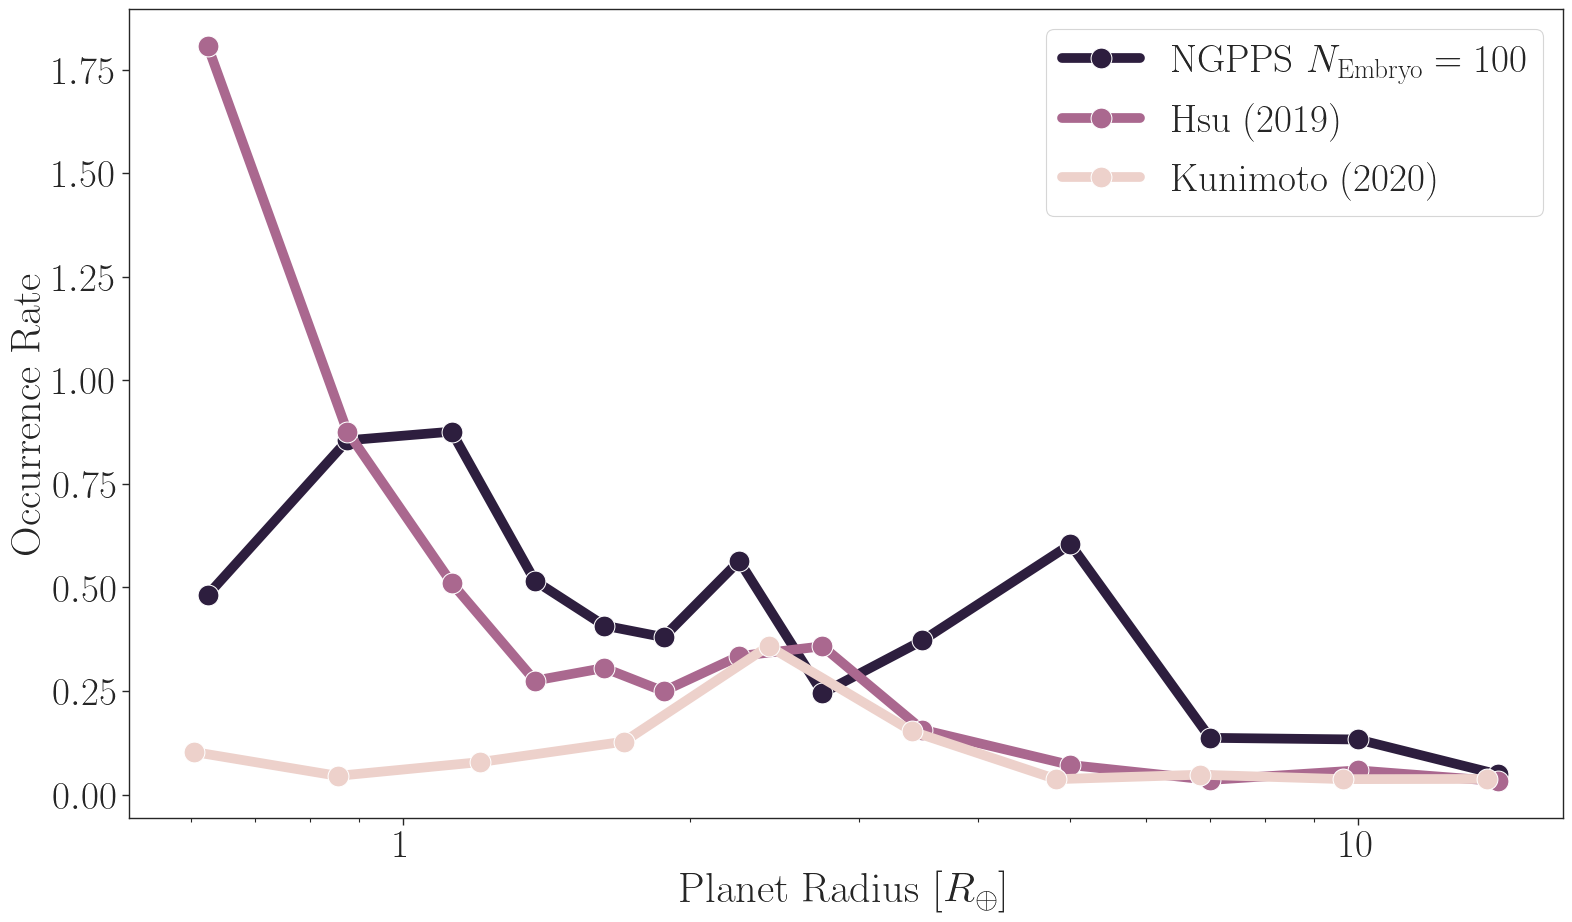

In [22]:
from matplotlib.ticker import ScalarFormatter

with sns.axes_style("ticks"):
    empirical_occurence_rate_lineplot = sns.lineplot(
        data=occurence_rate_dataframe,
        x="Planet Radius [$R_\oplus$]",
        y="Occurrence Rate",
        hue="Source",
        marker="o",
        palette=get_palette(3, reverse=True),
        linewidth=7,
        markersize=15,
    )
# make xaxis logarithmic
empirical_occurence_rate_lineplot.set_xscale("log")
empirical_occurence_rate_lineplot.xaxis.set_major_formatter(ScalarFormatter())

# adjust the line width for the legend
for line in empirical_occurence_rate_lineplot.legend().get_lines():
    line.set_linewidth(7)


FigureProcessor(empirical_occurence_rate_lineplot.figure).save(
    f"empirical_occurence_rate.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)